# MIT-BIH Data Exploration

Import Library

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #turn off irrelevant scipy future warning
import importlib
import random
import time
import pandas as pd
import numpy as np
from collections import Counter
from scipy import signal
from scipy.signal import find_peaks, resample
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import sys
import warnings
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import shutil

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data folder from Google Drive

source_folder = '/content/drive/MyDrive/BCC/mit_data'
destination_folder = '/content/mit_data'

shutil.copytree(source_folder, destination_folder)

'/content/mit_data'

## Explore data

In [4]:
# Explore all data label from the original paper

print("MIT-BIH DATABASES CONDITIONS:\n")

classes_further= {'N':'Normal beat','L':'Left bundle branch block beat','R':'Right bundle branch block beat',
'A':'Atrial premature beat','a':'Aberrated atrial premature beat','J':'Nodal (junctional) premature beat',
'S':'Supraventricular premature beat','V':'Premature ventricular contraction','F':'Fusion of ventricular and normal beat',
'[':'Start of ventricular flutter/fibrillation','!':'Ventricular flutter wave',']':'End of ventricular flutter/fibrillation','e':'Atrial escape beat',
'j':'Nodal (junctional) escape beat','E':'Ventricular escape beat','/':'Paced beat',
'f':'Fusion of paced and normal beat','x':'Non-conducted P-wave (blocked APB)','Q':'Unclassifiable beat',
'|':'Isolated QRS-like artifact'}

classes_further

MIT-BIH DATABASES CONDITIONS:



{'N': 'Normal beat',
 'L': 'Left bundle branch block beat',
 'R': 'Right bundle branch block beat',
 'A': 'Atrial premature beat',
 'a': 'Aberrated atrial premature beat',
 'J': 'Nodal (junctional) premature beat',
 'S': 'Supraventricular premature beat',
 'V': 'Premature ventricular contraction',
 'F': 'Fusion of ventricular and normal beat',
 '[': 'Start of ventricular flutter/fibrillation',
 '!': 'Ventricular flutter wave',
 ']': 'End of ventricular flutter/fibrillation',
 'e': 'Atrial escape beat',
 'j': 'Nodal (junctional) escape beat',
 'E': 'Ventricular escape beat',
 '/': 'Paced beat',
 'f': 'Fusion of paced and normal beat',
 'x': 'Non-conducted P-wave (blocked APB)',
 'Q': 'Unclassifiable beat',
 '|': 'Isolated QRS-like artifact'}

In [6]:
# Define function to get all data

def all_patients():

    onlyfiles = [f for f in listdir(os.getcwd()+'/mit_data') if isfile(join(os.getcwd()+'/mit_data', f))]
    return np.unique([file[0:3] for file in onlyfiles])[1:].tolist()

In [7]:
# Define function to normalize the signal

def z_norm(result):

    result = (result-min(result))/(max(result)-min(result))
    return result

In [8]:
# Define function to get a patient data and visulaize the ECG signal

def get_patient_data(patient,norm=True, sample_plot=False):

    widths= [4,8,11,6,3,5,5,8]

    patient=str(patient)
    ecg_notes= pd.read_fwf('mit_data/{}annotations.txt'.format(patient),widths=widths).drop(['Unnamed: 0'],axis=1)
    ecg_data= pd.read_csv('mit_data/{}.csv'.format(patient))
    ecg_data.columns= ['samp_num','signal','V']
    ecg_notes=ecg_notes[['Sample #','Type','Aux']]
    ecg_notes.columns=['sample_num','type','aux']

    if norm == True:
        ecg_data.signal= z_norm(ecg_data.signal)

    if sample_plot == True:
        peaklist= ecg_notes.sample_num.astype(int).values
        plt.figure()
        b=np.random.choice(len(ecg_data.signal))
        plt.plot(ecg_data.signal)
        plt.xlim(b,b+5000)
        plt.plot(peaklist, ecg_data.signal[peaklist], "x")
        plt.title('  Sample Patient {} data'.format(patient))
        return None

    return ecg_data.signal, ecg_notes

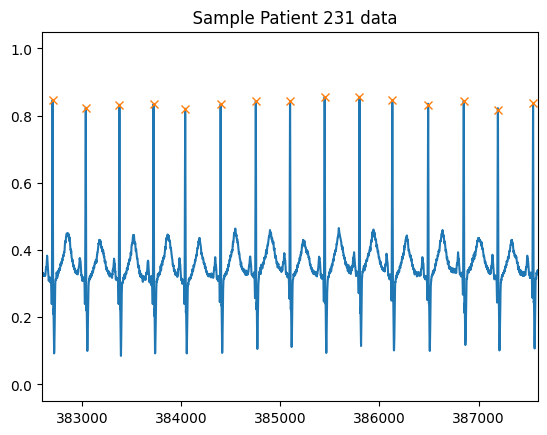

In [9]:
get_patient_data(patient=231,norm=True,sample_plot=True)

In [10]:
# Look at top 10 types of ECG beats in the data

allp=[]

for p in all_patients():
    sig,notes=get_patient_data(p)
    allp.extend(notes.type.values.tolist())

Counter(allp).most_common(10)

[('N', 75052),
 ('L', 8075),
 ('R', 7259),
 ('V', 7130),
 ('/', 7028),
 ('A', 2546),
 ('+', 1291),
 ('f', 982),
 ('F', 803),
 ('~', 616)]

In [12]:
# Define function to plot the distrubution of ECG types (by type and by patient)

def distribution_bar(patients,classes,classes_reducer=None):

    patient_dic= {}
    for patient in patients:
        sig,ecg_notes= get_patient_data(patient)
        patient_list= []
        for c in classes.values():
            summed=0
            if classes_reducer != None:
                for i in classes_reducer[c]:
                    summed += Counter(ecg_notes.type)[i]
                patient_list.append((c, summed))
            else:
                patient_list.append((c, Counter(ecg_notes.type)[c]))
        patient_dic[patient]= patient_list

    r_len = len(patients)
    barWidth = 0.25
    bars={}
    r={}
    for i in range(len(classes)):
        bars[i] = [x[i][1] for x in list(patient_dic.values())]
        if i == 0:
            r[0] = np.arange(r_len).tolist()
        else:
            r[i] = [x + 1/8 for x in r[i-1]]


    plt.figure(figsize=(25,20))
    plt.subplot(211)
    condition_count={}
    for condition,count in bars.items():
        condition_count[condition] = sum(count)

    s = pd.Series(
        list(condition_count.values()),
        index = [classes[i] for i in list(condition_count.keys())])
    s.plot(kind='bar')
    plt.ylabel('Count')
    plt.xlabel('Condition')

    plt.subplot(212)
    for i in range(0,len(classes)):
        plt.bar(r[i], bars[i], width=barWidth, edgecolor='white', label=classes[i])
    n=r[0]
    plt.xticks([n + barWidth for n in range(r_len)],patients)
    plt.ylabel('Count', fontweight='bold')
    plt.xlabel('Patients ({})'.format(r_len), fontweight='bold')
    plt.legend()
    plt.show()

    return patient_dic

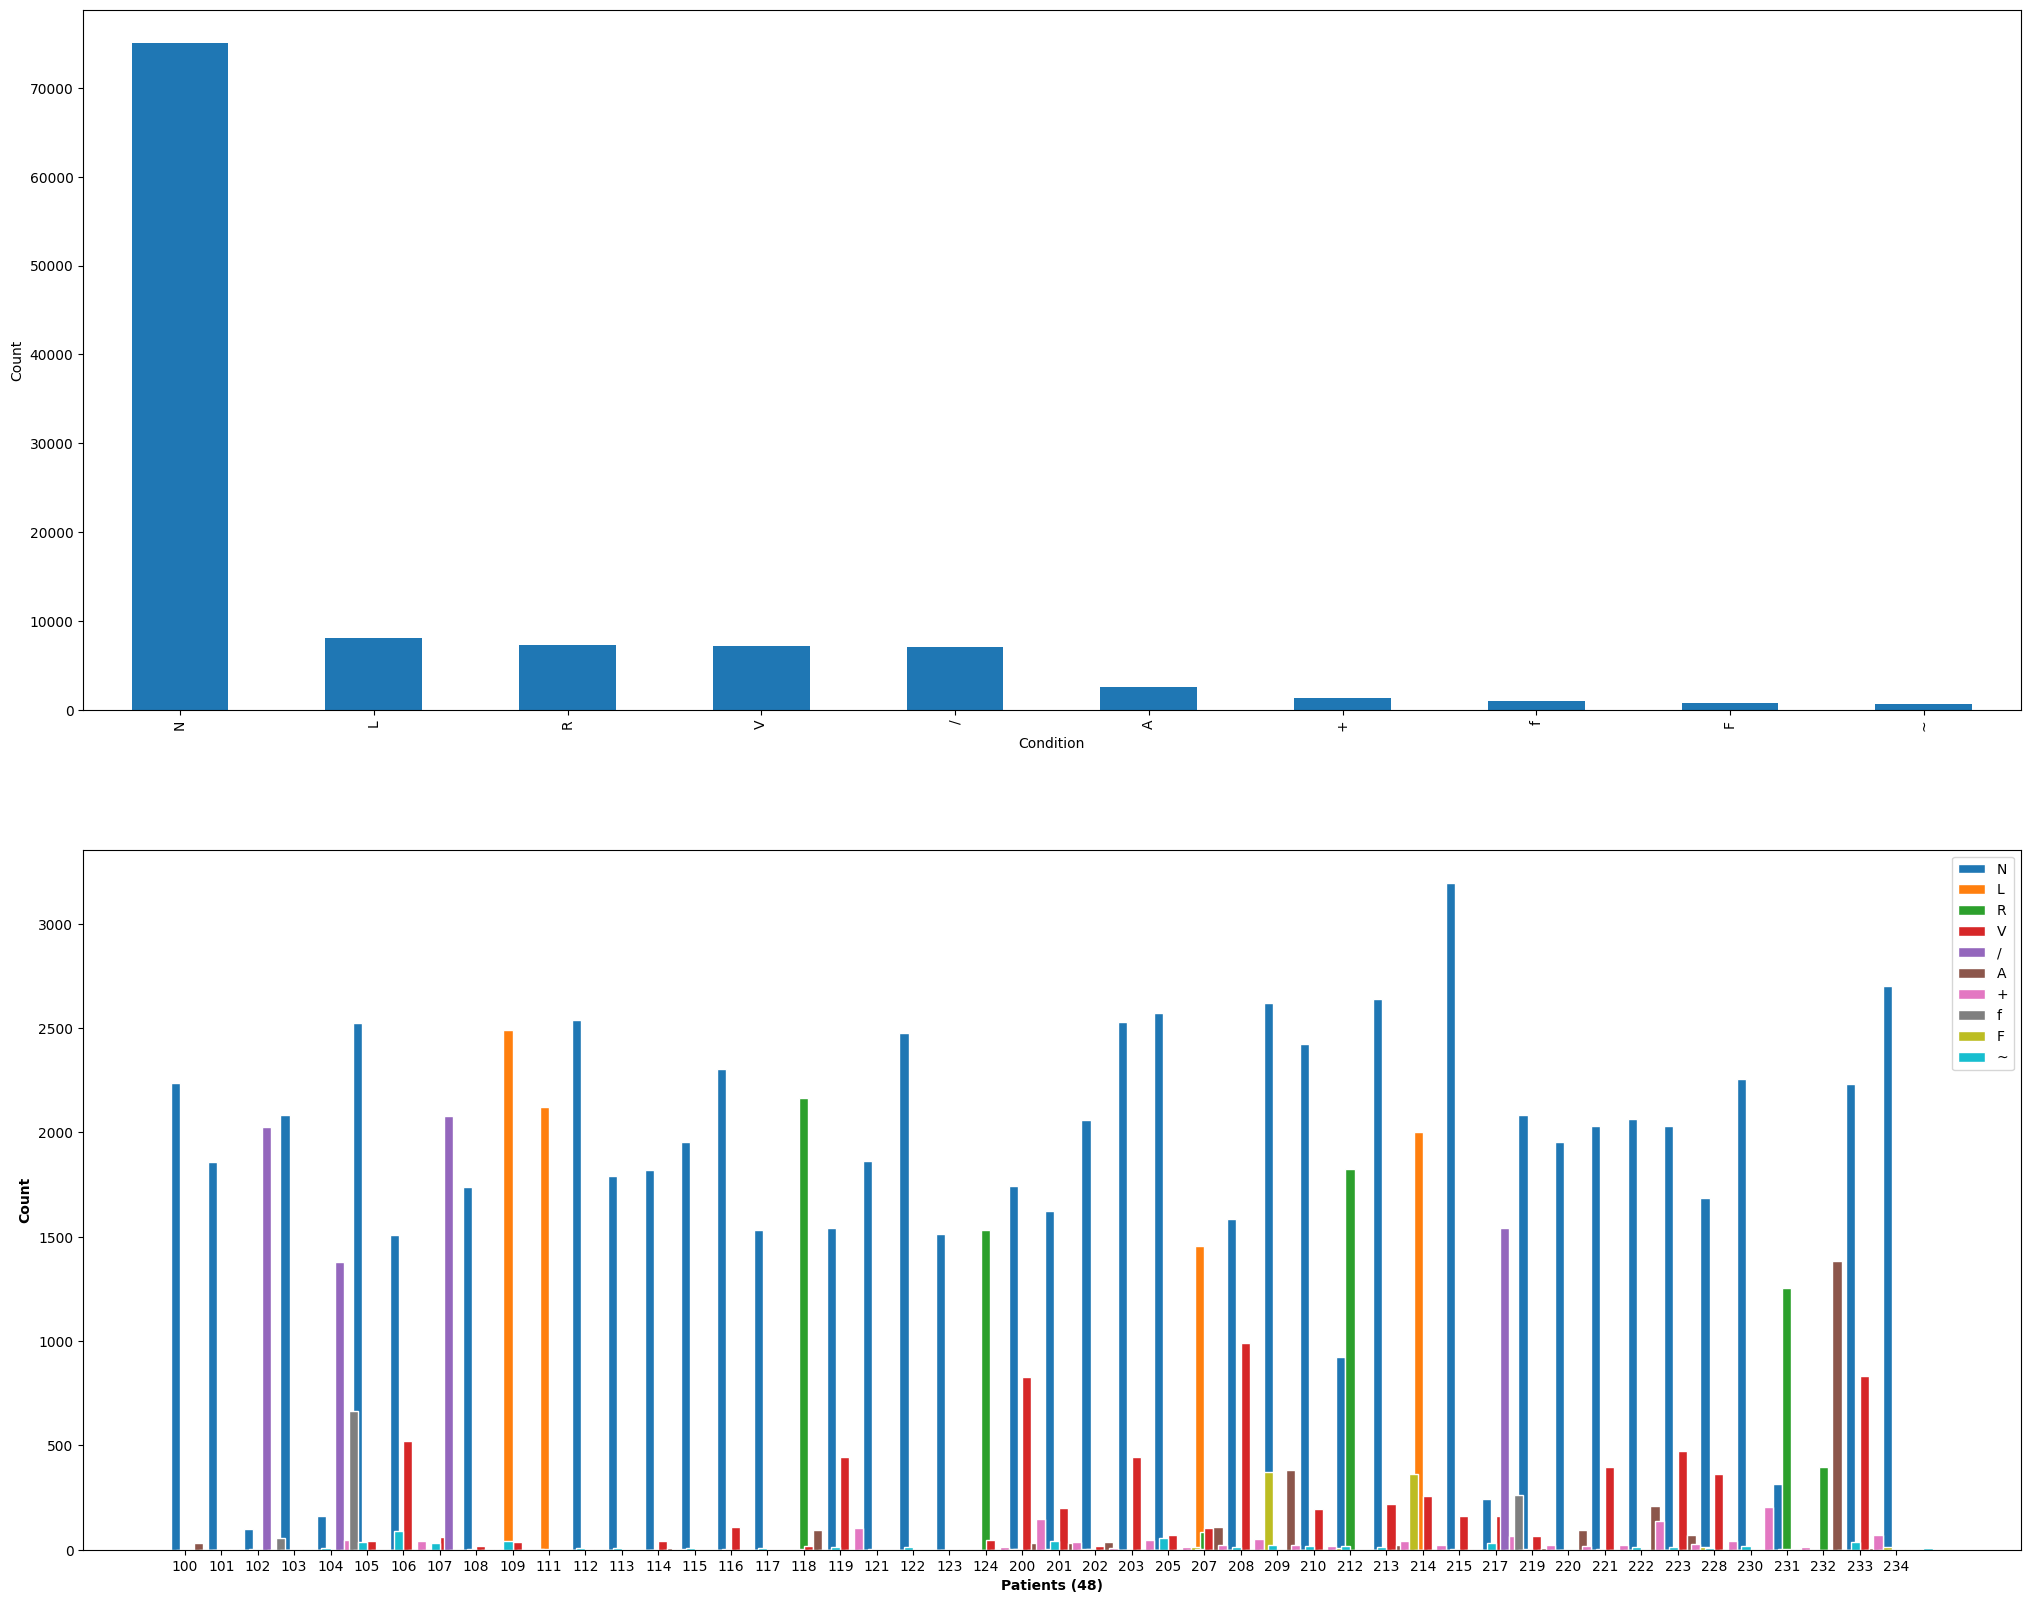

In [13]:
classes= {0:'N',1:'L',2:'R',3:'V',4:'/',5:'A',6:'+',7:'f',8:'F',9:'~'}
patient_dic=distribution_bar(patients=all_patients(),classes=classes)

In [14]:
classes= {0:'N',1:'S',2:'V',3:'F',4:'Q'}
classes_reducer={'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}
for c, subclass in classes_reducer.items():
    print('For class:',c, '({})'.format(classes_further[c]))
    for i in subclass:
        print("  ({})".format(i), classes_further[i])

For class: N (Normal beat)
  (N) Normal beat
  (L) Left bundle branch block beat
  (R) Right bundle branch block beat
  (e) Atrial escape beat
  (j) Nodal (junctional) escape beat
For class: S (Supraventricular premature beat)
  (S) Supraventricular premature beat
  (A) Atrial premature beat
  (a) Aberrated atrial premature beat
  (J) Nodal (junctional) premature beat
For class: V (Premature ventricular contraction)
  (V) Premature ventricular contraction
  (E) Ventricular escape beat
For class: F (Fusion of ventricular and normal beat)
  (F) Fusion of ventricular and normal beat
For class: Q (Unclassifiable beat)
  (/) Paced beat
  (Q) Unclassifiable beat
  (f) Fusion of paced and normal beat


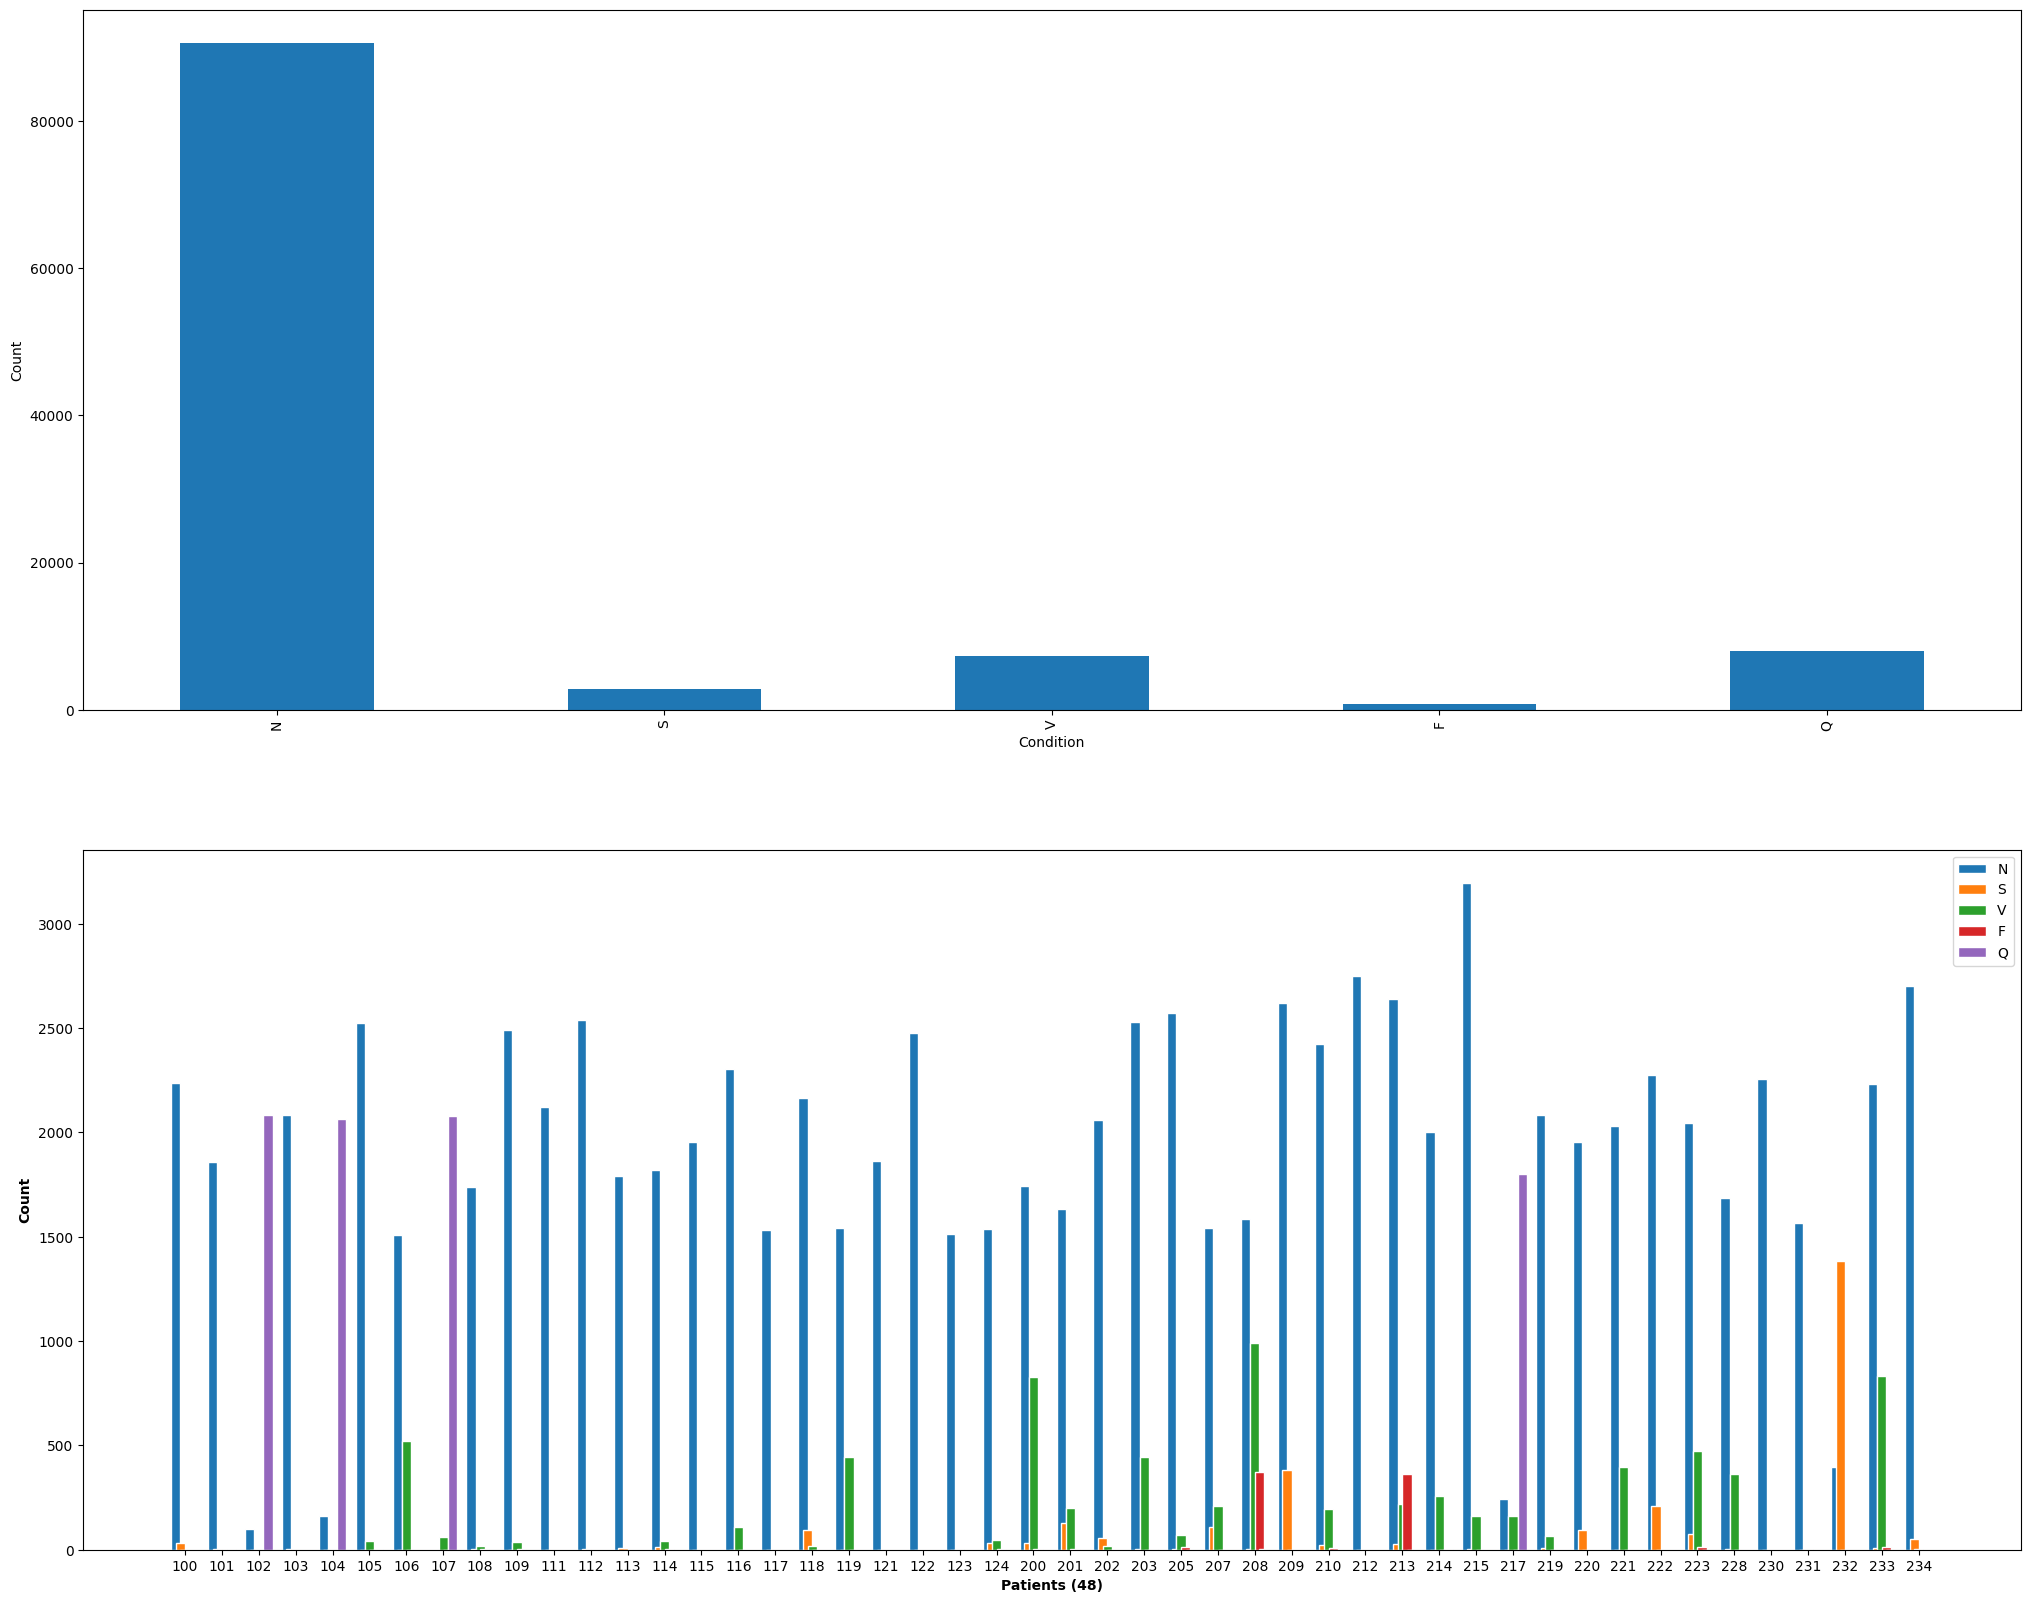

In [15]:
patient_dic=distribution_bar(patients=all_patients(),
                             classes=classes,
                             classes_reducer=classes_reducer)

## Process data

### Moving avarage

In [16]:
# Define function for moving average

def moving_average(x,window):
    return np.convolve(x, np.ones((window,))/window, mode='valid')

In [17]:
# Defince function to perform and visulize moving average

def plot_moving_average(patient,length,window=10):
    print("PATIENT: {}\n".format(patient))
    sig,notes= get_patient_data(patient,norm=False)
    m=moving_average(sig,10)
    n = np.random.choice(10*length)
    plt.figure(figsize=(10,5))

    plt.plot(z_norm(sig)[0:length])
    m=moving_average(z_norm(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.show()

PATIENT: 217



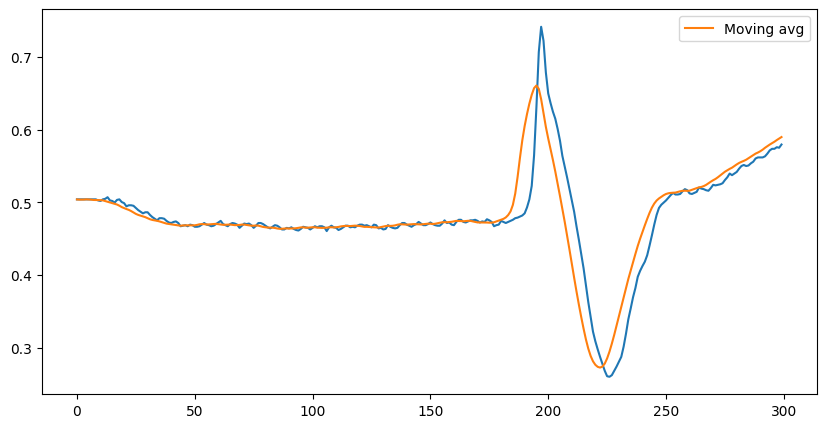

In [18]:
patient=random.choice(all_patients())
plot_moving_average(patient=patient,length=300)

###Butterworth low pass filter

In [19]:
# Get random patient ECG
patient=random.choice(all_patients())
sig,notes= get_patient_data(patient,norm=False)
sig

0          949
1          949
2          949
3          949
4          949
          ... 
649995     984
649996     979
649997     977
649998     975
649999    1024
Name: signal, Length: 650000, dtype: int64

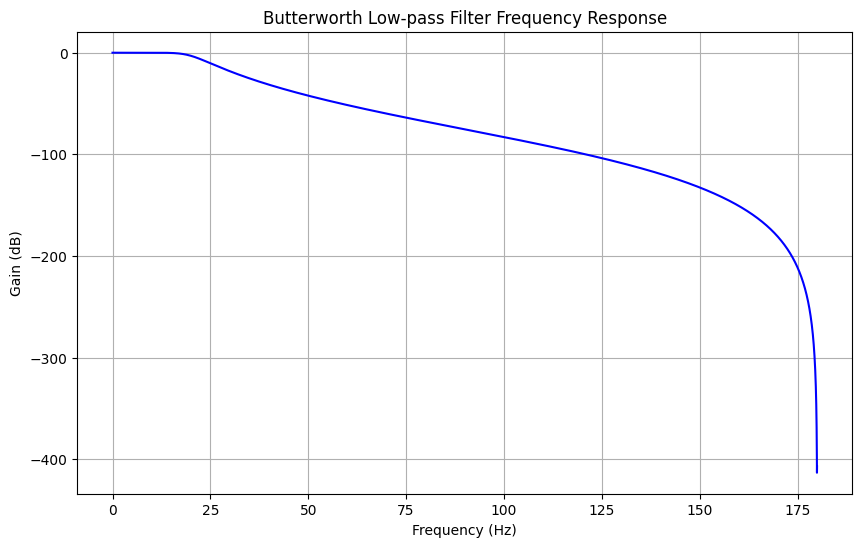

In [20]:
from scipy.signal import freqz

fc = 20  # Cutoff frequency
fs = 360  # Sampling frequency
n = 5  # Filter order

# Define the Butterworth low-pass filter function

def butter_lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define the Butterworth low-pass filter coefficients
b, a = butter(n, fc/(fs/2), btype='low')

# Frequency response
w, h = freqz(b, a, worN=8000)
frequency = fs * 0.5 * w / np.pi

# Plot the filter
plt.figure(figsize=(10, 6))
plt.plot(frequency, 20 * np.log10(abs(h)), 'b')
plt.title("Butterworth Low-pass Filter Frequency Response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid()
plt.show()

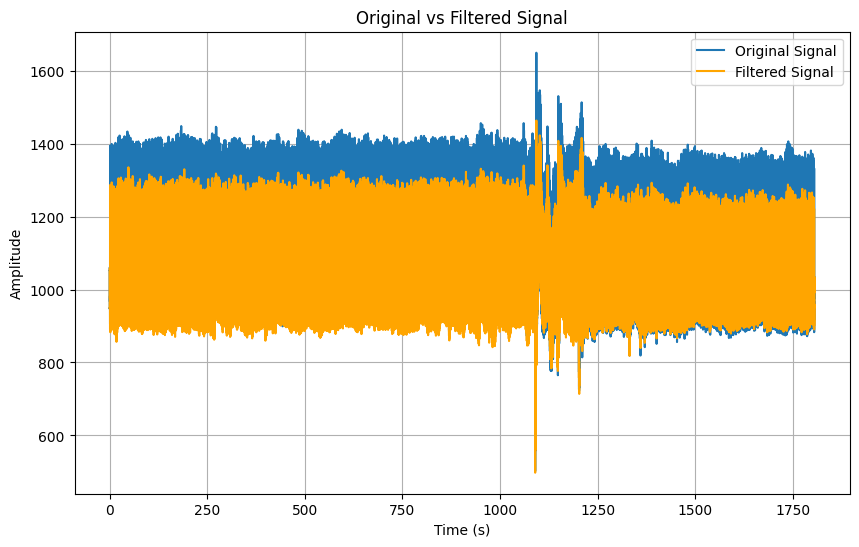

In [21]:
# Apply the filter to the signal

signal_data = sig.values
filtered_signal = butter_lowpass_filter(signal_data, fc, fs, n)

# Plot the original and filtered signal

time = np.arange(len(signal_data)) / fs
plt.figure(figsize=(10, 6))
plt.plot(time, signal_data, label='Original Signal')
plt.plot(time, filtered_signal, label='Filtered Signal', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Filtered Signal')
plt.grid(True)
plt.legend()
plt.show()

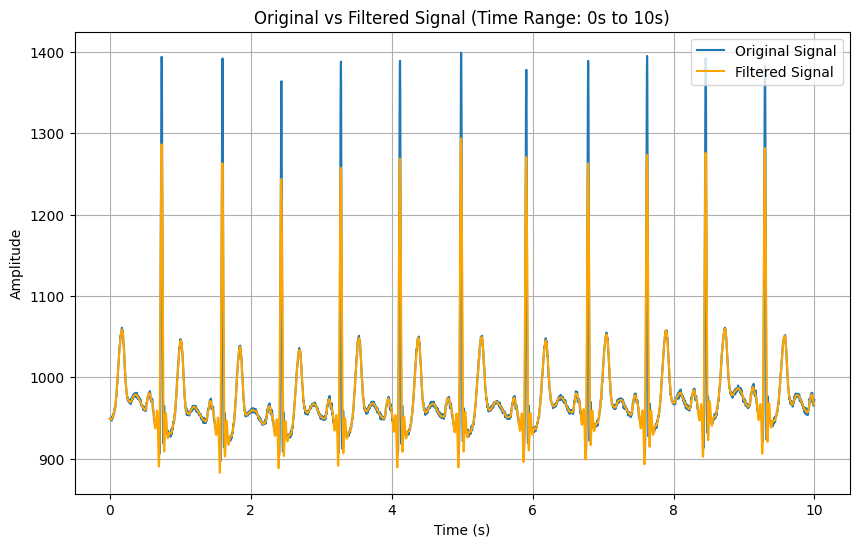

In [22]:
start_time = 0
end_time = 10

start_index = int(start_time * fs)
end_index = int(end_time * fs)

# Plot the original signal and filtered signal for the specified range of time
plt.figure(figsize=(10, 6))
plt.plot(time[start_index:end_index], signal_data[start_index:end_index], label='Original Signal')
plt.plot(time[start_index:end_index], filtered_signal[start_index:end_index], label='Filtered Signal', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Filtered Signal (Time Range: {}s to {}s)'.format(start_time, end_time))
plt.grid(True)
plt.legend()
plt.show()

###Isolate heart beats

#ECG Categorization Dataset (Kaggle)

Import Library

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import mlxtend

Reproducibility

In [24]:
random_seed = 0
np.random.seed(0)

##Data preparation

###Loading the data

In [25]:
train = pd.read_csv("/content/drive/MyDrive/BCC/mit_train.csv")
test = pd.read_csv("/content/drive/MyDrive/BCC/mit_test.csv")

In [26]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


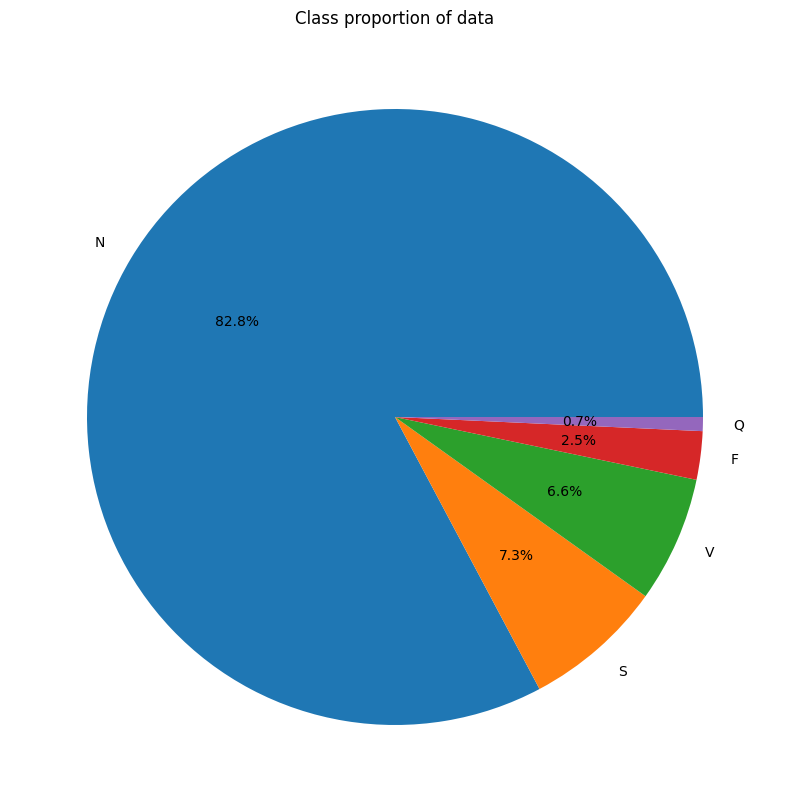

In [29]:
# Explore distribution of classes in the training dataset

plt.figure(figsize=(10, 10))
plt.pie(train.iloc[:, 187].value_counts(),
        labels=['N', 'S', 'V', 'F', 'Q'],
        autopct='%1.1f%%',
        )

plt.title('Class proportion of data')
plt.show()

###Data splitting

In [30]:
# Load the pre-splitted data

X_train, y_train = train.iloc[:, :187], train.iloc[:, 187]
X_test, y_test = test.iloc[:, :187], test.iloc[:, 187]

In [31]:
# Re-check data dimension and distribution

print("Train shape", X_train.shape)
print("Test shape", X_test.shape)
print("Value count for train dataset (target):\n", y_train.value_counts())
print("Value count for test dataset (target):\n", y_test.value_counts())

print("percentages for train dataset (target):\n", 100* y_train.value_counts() / len(y_train))
print("percentages for test dataset (target):\n", 100 * y_test.value_counts() / len(y_test))

Train shape (87554, 187)
Test shape (21892, 187)
Value count for train dataset (target):
 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
Value count for test dataset (target):
 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64
percentages for train dataset (target):
 0.0    82.772917
4.0     7.345181
2.0     6.610777
1.0     2.539005
3.0     0.732120
Name: 187, dtype: float64
percentages for test dataset (target):
 0.0    82.760826
4.0     7.345149
2.0     6.614288
1.0     2.539741
3.0     0.739996
Name: 187, dtype: float64


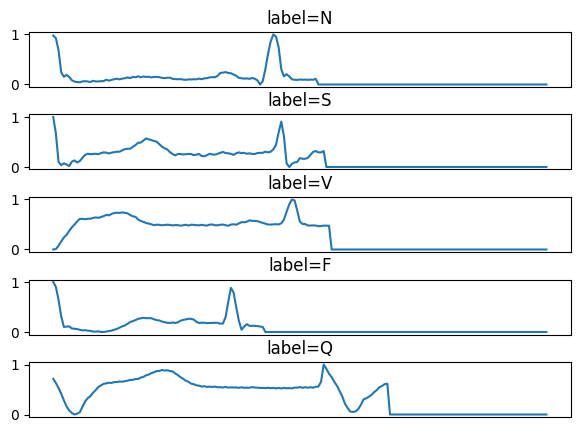

In [32]:
# Plot samples of ECG from each class

labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,1, figsize=(7,5), gridspec_kw={'hspace': 0.5})

for i in range(5):
    ax[i].plot(X_train[y_train==i].iloc[0])
    ax[i].set_title(f'label={labels[i]}')
    ax[i].set_xticks([])

### Data normalization

In [64]:
# Normalize the ECG signal

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

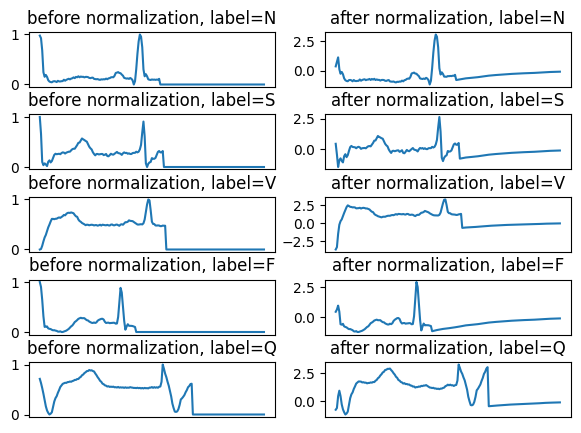

In [65]:
# Plot samples of ECG and normalized ECG from each class

labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,2, figsize=(7,5), gridspec_kw={'hspace': 0.5})

for i in range(5):
    ax[i][0].plot(X_train[y_train==i].iloc[0])
    ax[i][1].plot(X_train_norm[y_train==i][0])
    ax[i][0].set_title(f'before normalization, label={labels[i]}')
    ax[i][0].set_xticks([])
    ax[i][1].set_xticks([])
    ax[i][1].set_title(f'after normalization, label={labels[i]}')

In [66]:
from keras.utils import to_categorical

# one hot encoding for target variable

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape, y_test.shape)

(87554, 5) (21892, 5)


## Classification Model with CNN

###Create model

In [68]:
# Set up model configuration

class Config_CNN:
    epochs = 100
    batch_size = 16
    exp_name = 1
    patience = 40
    initial_learning_rate= 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    reduce_lr_every_10_epochs = True
    lr_reduction_rate = 0.5
    Conv1_filter_num = 32
    Conv1_filter_size = 3
    filepath_checkpoint = '/content/drive/MyDrive/BCC/CNN'+'/experiment_'+str(exp_name)+'_'+'.weights.h5'
    filepath_accuracy_plot = '/content/drive/MyDrive/BCC/CNN'+'/experiment_'+str(exp_name)+'_'+'.accuracy_plot.png'
    filepath_loss_plot = '/content/drive/MyDrive/BCC/CNN'+'/experiment_'+str(exp_name)+'_'+'.loss_plot.png'
    filepath_classification_report = '/content/drive/MyDrive/BCC/CNN'+'/experiment_'+str(exp_name)+'_'+'.classification_report.txt'

# Set up learning rate scheduler

def lr_scheduler(epoch, lr):
    if Config_CNN.reduce_lr_every_10_epochs and epoch % 10 == 0:
        return lr * Config_CNN.lr_reduction_rate
    else:
        return lr

# callback for the learning rate reduction schedule

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [69]:
# Design the CNN model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(Config_CNN.Conv1_filter_num, Config_CNN.Conv1_filter_size, activation='relu', input_shape=(187, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(Config_CNN.Conv1_filter_num//2, Config_CNN.Conv1_filter_size, activation='relu' ))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(120, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
model.add(tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [71]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=Config_CNN.filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

LR_plateu_callback = ReduceLROnPlateau(monitor = 'val_acc', min_delta = 0.001, patience = 20,
                                       factor = 0.5, cooldown = 0, verbose = 1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=Config_CNN.patience)

model.compile(optimizer=Config_CNN.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 185, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 92, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 16)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dropout (Dropout)           (None, 704)               0

###Training

In [ ]:
train_array = X_train_norm.to_numpy()
test_array = X_test_norm.to_numpy()
print("Train Dataframe shape (before reshaping):", train.shape)
print("Train Dataframe first 10 rows for comparison:")

print("train array shape before reshaping:", train_array.shape)
print("Train Array before reshaping first 10 rows for comparison:")

train_reshaped = train_array.reshape(train_array.shape[0], train_array.shape[1], 1)
test_reshaped = test_array.reshape(test_array.shape[0], test_array.shape[1], 1)
print("train array shape after reshaping:", train_reshaped.shape)
print("Train Array after reshaping first 10 rows for comparison:")

In [ ]:
cnn_model_history = model.fit(train_reshaped, y_train, epochs=Config_CNN.epochs, batch_size=Config_CNN.batch_size,
                              validation_data=(test_reshaped, y_test),
                              callbacks=[model_checkpoint_callback, early_stop_callback, LR_plateu_callback])

###Evaluate model

In [ ]:
# Plot train vs test accuracy
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title(f'Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(Config_CNN.filepath_accuracy_plot)
plt.show()
plt.close()

# Plot train vs test loss
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(Config_CNN.filepath_loss_plot)
plt.show()
plt.close()

predictions = model.predict(test_reshaped).argmax(axis=1)

In [ ]:
# Load the best model weights
best_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(Config_CNN.Conv1_filter_num, Config_CNN.Conv1_filter_size, activation='relu', input_shape=(187, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=3, strides=2),
    tf.keras.layers.Conv1D(Config_CNN.Conv1_filter_num//2, Config_CNN.Conv1_filter_size, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(120, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.Dense(5, activation='softmax')
])

best_model.load_weights(Config_CNN.filepath_checkpoint)

# Make predictions on the test set
test_predictions = best_model.predict(test_reshaped)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
classification_rep = classification_report(true_labels, test_predictions_labels, digits=4)
print("Classification Report:")
print(classification_rep)